In [1]:
import neutromeratio
from openmmtools.constants import kB
from simtk import unit
import numpy as np
import pickle
import mdtraj as md
import torchani
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import random

[utils.py:54 - get_tautomer_transformation()] Index of atom that moves: 11.
[utils.py:60 - get_tautomer_transformation()] Index of atom that donates hydrogen: 2
[utils.py:78 - get_tautomer_transformation()] Index of atom that accepts hydrogen: 5


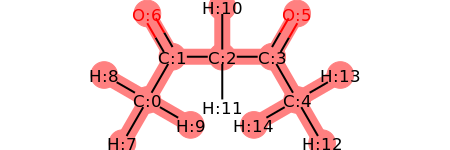

In [3]:
exp_results = pickle.load(open('../data/exp_results.pickle', 'rb'))

# specify the system you want to simulate
name = 'molDWRow_298'
#name = 'molDWRow_37'
#name = 'molDWRow_45'
#name = 'molDWRow_160'
#name = 'molDWRow_590'


from_mol_tautomer_idx = 1
to_mol_tautomer_idx = 2


t1_smiles = exp_results[name]['t1-smiles']
t2_smiles = exp_results[name]['t2-smiles']

# generate both rdkit molhttp://localhost:8888/notebooks/notebooks/testing-hybrid-structures.ipynb#
mols = { 't1' : neutromeratio.generate_rdkit_mol(t1_smiles), 't2' : neutromeratio.generate_rdkit_mol(t2_smiles) }
from_mol = mols[f"t{from_mol_tautomer_idx}"]
to_mol = mols[f"t{to_mol_tautomer_idx}"]
ani_input = neutromeratio.from_mol_to_ani_input(from_mol)

tautomer_transformation = neutromeratio.get_tautomer_transformation(from_mol, to_mol)
neutromeratio.generate_hybrid_structure(ani_input, tautomer_transformation, neutromeratio.ani.ANI1_force_and_energy)

In [4]:
# define the alchemical atoms
alchemical_atoms=[tautomer_transformation['acceptor_hydrogen_idx'], tautomer_transformation['donor_hydrogen_idx']]

In [5]:
tautomer_transformation

{'donor_idx': 2,
 'hydrogen_idx': 11,
 'acceptor_idx': 5,
 'donor_hydrogen_idx': 11,
 'acceptor_hydrogen_idx': 15}

In [ ]:
np.random.seed(0)

# extract hydrogen donor idx and hydrogen idx for from_mol
platform = 'cpu'
device = torch.device(platform)
model = neutromeratio.ani.LinearAlchemicalSingleTopologyANI(device=device, alchemical_atoms=alchemical_atoms, ani_input=ani_input)
model = model.to(device)
torch.set_num_threads(2)

# perform initial sampling
ani_trajs = []
n_steps = 10000
energy_function = neutromeratio.ANI1_force_and_energy(device = device,
                                          model = model,
                                          atom_list = ani_input['hybrid_atoms'],
                                          platform = platform,
                                          tautomer_transformation = tautomer_transformation)
energy_function.restrain_acceptor = True
energy_function.restrain_donor = True

langevin = neutromeratio.LangevinDynamics(atom_list = ani_input['hybrid_atoms'],
                            temperature = 300*unit.kelvin,
                            force = energy_function)

x0 = np.array(ani_input['hybrid_coords']) * unit.angstrom
energie_list = []


for lamb in np.linspace(0, 1, 10):
    print(lamb)
    energy_function.lambda_value = lamb
    
    equilibrium_samples, energies = langevin.run_dynamics(x0, n_steps, stepsize=1.0 * unit.femtosecond)
    energie_list.append(energies)
    equilibrium_samples = [x / unit.nanometer for x in equilibrium_samples]
    ani_traj = md.Trajectory(equilibrium_samples, ani_input['hybrid_topolog'])

    ani_trajs.append(ani_traj)

0.0


In [7]:
neutromeratio.utils.generate_nglview_object(ani_trajs[4], tautomer_transformation)

Hydrogen in GREEN  is real at lambda: 0.
Hydrogen in YELLOW is real at lambda: 1.


NGLWidget(count=11)

In [ ]:
import matplotlib.pyplot as plt

for energy in energie_list:
    e = [x / unit.kilocalorie_per_mole for x in energy]
    plt.plot(e, label='lambda: {}'.format(str(lamb)))

In [ ]:
energy_function.calculate_energy(x0)
energy_function.calculate_force(x0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

        
        
# get the derivation of the old value of x
d_x = - energy_function.calculate_force(x0)
        
# get your new value of x by adding the previous, the multiplication of the derivative and the learning rate
x_new = x_prev + (l_r * d_x)
        
        # append the new value of x to a list of all x-s for later visualization of path
        x_list.append(x_new)
        
        # append the new value of y to a list of all y-s for later visualization of path
        y_list.append(function(x_new))

    print ("Local minimum occurs at: "+ str(x_new))
    print ("Number of steps: " + str(len(x_list)))
    
    
    plt.subplot(1,2,2)
    plt.scatter(x_list,y_list,c="g")
    plt.plot(x_list,y_list,c="g")
    plt.plot(x,function(x), c="r")
    plt.title("Gradient descent")
    plt.show()

    plt.subplot(1,2,1)
    plt.scatter(x_list,y_list,c="g")
    plt.plot(x_list,y_list,c="g")
    plt.plot(x,function(x), c="r")
    plt.xlim([1.0,2.1])
    plt.title("Zoomed in Gradient descent to Key Area")
    plt.show()

In [ ]:
from simtk import unit

In [ ]:
def f(x):
    return energy_function.calculate_energy(x)

def df(x):
    f, e = energy_function.calculate_force(x)
    return f._value

In [ ]:
ener

In [ ]:
x = x0.in_units_of(unit.nanometer)

for i in range(1, 100):
    print(i)
    s = -df(x)
    x = x.value_in_unit(unit.nanometer) + 0.001 * s
    x = x * unit.nanometer
    print(x)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

function = lambda x: (x ** 3)-(3 *(x ** 2))+7

#Get 1000 evenly spaced numbers between -1 and 3 (arbitratil chosen to ensure steep curve)
x = np.linspace(-1,3,500)

#Plot the curve
plt.plot(x, function(x))
plt.show()


In [ ]:
def deriv(x):
    
    '''
    Description: This function takes in a value of x and returns its derivative based on the 
    initial function we specified.
    
    Arguments:
    
    x - a numerical value of x 
    
    Returns:
    
    x_deriv - a numerical value of the derivative of x
    
    '''
    
    x_deriv = 3* (x**2) - (6 * (x))
    return x_deriv


In [ ]:
def step(x_new, x_prev, precision, l_r):
    
    '''
    Description: This function takes in an initial or previous value for x, updates it based on 
    steps taken via the learning rate and outputs the most minimum value of x that reaches the precision satisfaction.
    
    Arguments:
    
    x_new - a starting value of x that will get updated based on the learning rate
    
    x_prev - the previous value of x that is getting updated to the new one
    
    precision - a precision that determines the stop of the stepwise descent 
    
    l_r - the learning rate (size of each descent step)
    
    Output:
    
    1. Prints out the latest new value of x which equates to the minimum we are looking for
    2. Prints out the the number of x values which equates to the number of gradient descent steps
    3. Plots a first graph of the function with the gradient descent path
    4. Plots a second graph of the function with a zoomed in gradient descent path in the important area
    
    '''
    
    # create empty lists where the updated values of x and y wil be appended during each iteration
    
    x_list, y_list = [x_new], [function(x_new)]
    # keep looping until your desired precision
    while abs(x_new - x_prev) > precision:
        
        # change the value of x
        x_prev = x_new
        
        # get the derivation of the old value of x
        d_x = - deriv(x_prev)
        
        # get your new value of x by adding the previous, the multiplication of the derivative and the learning rate
        x_new = x_prev + (l_r * d_x)
        
        # append the new value of x to a list of all x-s for later visualization of path
        x_list.append(x_new)
        
        # append the new value of y to a list of all y-s for later visualization of path
        y_list.append(function(x_new))

    print ("Local minimum occurs at: "+ str(x_new))
    print ("Number of steps: " + str(len(x_list)))
    
    
    plt.subplot(1,2,2)
    plt.scatter(x_list,y_list,c="g")
    plt.plot(x_list,y_list,c="g")
    plt.plot(x,function(x), c="r")
    plt.title("Gradient descent")
    plt.show()

    plt.subplot(1,2,1)
    plt.scatter(x_list,y_list,c="g")
    plt.plot(x_list,y_list,c="g")
    plt.plot(x,function(x), c="r")
    plt.xlim([1.0,2.1])
    plt.title("Zoomed in Gradient descent to Key Area")
    plt.show()


In [ ]:
step(0.5, 0, 0.001, 0.05)
